In [10]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [11]:
data_1h = pd.read_csv('data/indicadores_test_1h.csv')
data_1h

,Timestamp,Close,xg_boost_buy,reg_log_buy,SVC_buy,xg_boost_sell,reg_log_sell,SVC_sell
0,1610051400,130.860000,False,False,True,True,True,True
1,1610116200,130.380004,False,False,True,True,True,True
2,1610119800,131.070007,False,False,True,True,True,True
3,1610123400,132.154998,False,False,True,True,True,True
4,1610127000,131.115005,False,False,True,True,True,True
...,...,...,...,...,...,...,...,...
5701,1703871000,191.899993,False,False,True,True,True,True
5702,1703874600,192.119995,False,False,True,True,True,True
5703,1703878200,192.679992,False,False,True,True,True,True
5704,1703881800,192.520004,False,False,True,True,True,True


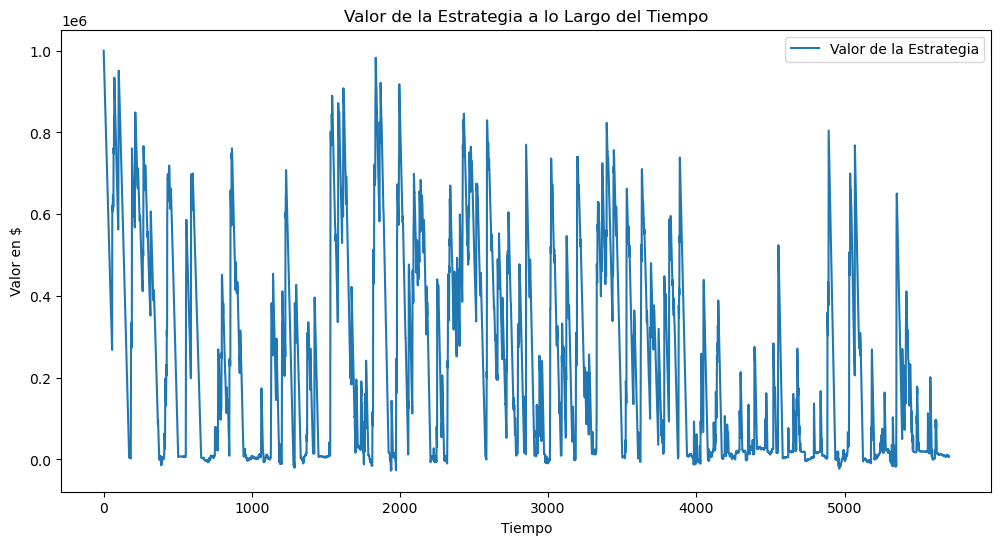

Valor de la estrategia:  7616.543467876871


In [18]:
import pandas as pd
import matplotlib.pyplot as plt

# Asumiendo que 'data_1h' es un DataFrame de pandas que ya ha sido definido.

# Parámetros óptimos
stop_loss_long = 0.043223250201488095
take_profit_long = 0.04998083795768937
stop_loss_short = 0.0486233499852006
take_profit_short = 0.020625620334624544
n_shares_long = 100
n_shares_short = 100

# Variables de la estrategia
cash = 1_000_000
active_operations = []
com = 0.00125
strategy_value = [cash]

class Operation:
    def __init__(self, operation_type, bought_at, timestamp, n_shares, stop_loss, take_profit):
        self.operation_type = operation_type
        self.bought_at = bought_at
        self.timestamp = timestamp
        self.n_shares = n_shares
        self.sold_at = None
        self.stop_loss = stop_loss
        self.take_profit = take_profit

    def close(self, sold_at):
        self.sold_at = sold_at

# Ejecutar la estrategia
for i, row in data_1h.iterrows():
    # Cerrar operaciones activas
    temp_operations = []
    for op in active_operations:
        if op.operation_type == 'Long':
            if row.Close <= op.stop_loss or row.Close >= op.take_profit:
                cash += op.n_shares * row.Close * (1 - com)
                op.close(row.Close)
            else:
                temp_operations.append(op)
        elif op.operation_type == 'Short':
            if row.Close >= op.stop_loss or row.Close <= op.take_profit:
                cash += (op.bought_at - row.Close) * op.n_shares * (1 - com)  # Ajustar por comisión
                op.close(row.Close)
            else:
                temp_operations.append(op)
    active_operations = temp_operations

    # Abrir nuevas operaciones
    if 'SVC_buy' in row and row['SVC_buy'] and cash >= row.Close * n_shares_long * (1 + com):
        active_operations.append(Operation('Long', row.Close, row.name, n_shares_long,
                                           row.Close * (1 - stop_loss_long), row.Close * (1 + take_profit_long)))
        cash -= row.Close * n_shares_long * (1 + com)

    if 'reg_log_sell' in row and row['reg_log_sell'] and cash >= row.Close * n_shares_short * (1 + com):
        active_operations.append(Operation('Short', row.Close, row.name, n_shares_short,
                                           row.Close * (1 + stop_loss_short), row.Close * (1 - take_profit_short)))
        # Para una operación corta, se asume el "uso" del cash para abrir la posición, pero no se resta realmente.

    # Calcular el valor total de la estrategia
    total_value = cash + sum((row.Close - op.bought_at) * op.n_shares for op in active_operations if op.operation_type == 'Long') + \
                  sum((op.bought_at - row.Close) * op.n_shares for op in active_operations if op.operation_type == 'Short')
    strategy_value.append(total_value)

# Graficar el valor de la estrategia a lo largo del tiempo
plt.figure(figsize=(12, 6))
plt.plot(strategy_value, label='Valor de la Estrategia')
plt.title('Valor de la Estrategia a lo Largo del Tiempo')
plt.xlabel('Tiempo')
plt.ylabel('Valor en $')
plt.legend()
plt.show()
print("Valor de la estrategia: ", strategy_value[-1])
